# PREPROCESSING

In [3]:
RUN_NUM = "JOKE_4"
glove_path = "Models/glove.6B.100d.txt"

In [4]:
import json

with open("Data/reddit_jokes.json", "r", encoding="utf8") as f:
    data = json.load(f)

with open("Data/wocka.json", "r", encoding="utf8") as f:
    data2 = json.load(f)

In [5]:
import re
import numpy as np

In [6]:
print(len(data))
print(len(data2))

194553
10019


In [7]:
import string

scriptsSents = []
for joke in data:
    text = joke["title"].rstrip() + ' ' + joke["body"].rstrip()
    if len([w for w in text.split() if w]) > 500: continue
    for c in string.punctuation.replace("\'",''): text = text.replace(c,' ')
    scriptsSents.append( ' '.join([w.lower() for w in text.split() if w]) )
    
for joke in data2:
    text = joke["body"].rstrip()
    if len([w for w in text.split() if w]) > 500: continue
    for c in string.punctuation.replace("\'",''): text = text.replace(c,' ')
    scriptsSents.append( ' '.join([w.lower() for w in text.split() if w]) )
    
scripts = [sentence.split() for sentence in scriptsSents]
scriptsLengths = [len(tokens) for tokens in scripts]
len(scripts)

203567

In [8]:
scripts[-1]

['customer',
 'are',
 'you',
 'hispanic',
 'me',
 'no',
 'customer',
 'middle',
 'eastern',
 'me',
 'no',
 'customer',
 'egyptian',
 'me',
 'no',
 'customer',
 'what',
 'are',
 'you',
 'me',
 'chinese',
 'customer',
 'puts',
 'on',
 'offended',
 'face',
 'customer',
 'i',
 "don't",
 'appreciate',
 'you',
 'treating',
 'me',
 'like',
 "i'm",
 'dumb',
 'me',
 'excuse',
 'me',
 "i'm",
 'being',
 'honest',
 'customer',
 'no',
 'chinese',
 'person',
 'would',
 'ever',
 'have',
 'eyes',
 'as',
 'big',
 'as',
 'yours',
 'me',
 'mouth',
 'wide',
 'open']

In [9]:
from collections import Counter

vocabulary = list([word for sentence in scripts for word in sentence])
counts = Counter(vocabulary)
vocabulary = [w for w,f in counts.items()]
vocabulary.sort(key = lambda x: counts[x], reverse=True)
vocabulary = vocabulary[:10000]
print(vocabulary[:20])

['the', 'a', 'and', 'to', 'i', 'you', 'in', 'of', 'he', 'is', 'it', 'his', 'was', 'that', 'what', 'my', 'on', 'for', 'with', 'man']


In [10]:
word2id = {w:i+3 for i,w in enumerate(vocabulary)}
word2id["<pad>"] = 0
word2id["<unk>"] = 1
word2id["<endtoken>"] = 2

id2word = list(word2id.keys())
id2word.sort(key=lambda x: word2id[x])
print(id2word[:20])
print(len(id2word))

['<pad>', '<unk>', '<endtoken>', 'the', 'a', 'and', 'to', 'i', 'you', 'in', 'of', 'he', 'is', 'it', 'his', 'was', 'that', 'what', 'my', 'on']
10003


Average length: 45.415209734387204
Max length: 753


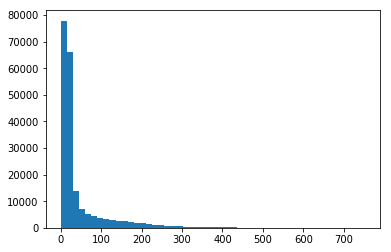

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
print(f"Average length: {sum(scriptsLengths)/len(scriptsLengths)}")
print(f"Max length: {max(scriptsLengths)}")
plt.hist(scriptsLengths, bins=50)
plt.show()

In [12]:
num_words = 50 #40 words each sentence
sum([l < num_words for l in scriptsLengths])/len(scriptsLengths)

0.7853777871658962

In [13]:
xindexs, yindexs = [], []
for i, wlist in enumerate(scripts):
    xarray = np.zeros( (num_words+1))
    numWords = len(wlist)
    j = 0
    for j, w in enumerate(wlist[:num_words-1]):
        if w in word2id.keys(): xarray[j] = word2id[w]
        else: xarray[j] = word2id["<unk>"] 
    xarray[j+1] = word2id["<endtoken>"]
    yindexs.append([ [id] for id in xarray])
    xindexs.append( xarray )

In [14]:
xdata = np.array(xindexs)
ydata = np.array(yindexs)
x = xdata[:,:-1]
y = ydata[:,1:,:]

In [15]:
print(x.shape)
print(y.shape)
print()
print(x[0].tolist())
print(y[0].tolist())

(203567, 50)
(203567, 50, 1)

[7.0, 594.0, 44.0, 8.0, 1579.0, 211.0, 87.0, 160.0, 1162.0, 1059.0, 104.0, 7.0, 27.0, 6.0, 87.0, 4422.0, 58.0, 8.0, 278.0, 1162.0, 3.0, 1171.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[[594.0], [44.0], [8.0], [1579.0], [211.0], [87.0], [160.0], [1162.0], [1059.0], [104.0], [7.0], [27.0], [6.0], [87.0], [4422.0], [58.0], [8.0], [278.0], [1162.0], [3.0], [1171.0], [2.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


# MODEL


In [16]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import datetime

In [17]:
import tensorflow as tf

# tf.config.list_physical_devices('GPU') # True/False

vocabulary_size = len(word2id.keys())
sentence_size = num_words

batch_size = 128
output_dim = 128

print(vocabulary_size)
print(sentence_size)

10003
50


In [ ]:
EMBEDDING_DIM = 100

embeddings_index = {}
f = open(glove_path, "r", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word2id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix[word2id["<unk>"]] = np.random.random_sample((EMBEDDING_DIM,))
print(embedding_matrix.shape)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIM, input_length=sentence_size, weights=[embedding_matrix], mask_zero=True, trainable=True))
model.add(LSTM(units=256, recurrent_dropout=0.25, dropout=0.25, return_sequences=True))
model.add(LSTM(units=256, recurrent_dropout=0.25, dropout=0.25, return_sequences=True))
model.add(TimeDistributed(Dense(units=vocabulary_size, activation="softmax")))

In [18]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam()
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1000300   
_________________________________________________________________
lstm (LSTM)                  (None, 50, 256)           365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 10003)         2570771   
Total params: 4,461,951
Trainable params: 4,461,951
Non-trainable params: 0
_________________________________________________________________


In [19]:
%load_ext tensorboard
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = EarlyStopping(patience=5)

In [25]:
model.fit(x=x, y=y, batch_size=batch_size, epochs=15, validation_split=.15, callbacks=[tensorboard_callback])

Train on 173031 samples, validate on 30536 samples
Epoch 1/15
173031/173031 [==============================] - 384s 2ms/sample - loss: 1.9144 - accuracy: 0.3048 - val_loss: 2.6002 - val_accuracy: 0.2864
Epoch 2/15
173031/173031 [==============================] - 326s 2ms/sample - loss: 1.9052 - accuracy: 0.3062 - val_loss: 2.6049 - val_accuracy: 0.2849
Epoch 3/15
173031/173031 [==============================] - 325s 2ms/sample - loss: 1.8963 - accuracy: 0.3077 - val_loss: 2.5892 - val_accuracy: 0.2882
Epoch 4/15
173031/173031 [==============================] - 325s 2ms/sample - loss: 1.8883 - accuracy: 0.3090 - val_loss: 2.5858 - val_accuracy: 0.2887
Epoch 5/15
173031/173031 [==============================] - 323s 2ms/sample - loss: 1.8810 - accuracy: 0.3103 - val_loss: 2.5799 - val_accuracy: 0.2899
Epoch 6/15
173031/173031 [==============================] - 328s 2ms/sample - loss: 1.8738 - accuracy: 0.3117 - val_loss: 2.5779 - val_accuracy: 0.2903
Epoch 7/15
173031/173031 [===========

In [26]:
RUN_NUM = "JOKE_5"

model.save(f"Models/model_{RUN_NUM}.h5")
import json

with open(f"Mappings/word2id_{RUN_NUM}.json", "w", encoding="utf8") as f:
    json.dump(word2id, f, indent=4)

# PREDICTIONS

In [1]:
RUN_NUM = "JOKE_3"
PREFIX = ""#"/content/drive/My Drive/Colab Notebooks/Language Modelling/"

In [2]:
from tensorflow.keras.models import load_model
import json
import numpy as np
with open(PREFIX+f"Mappings/word2id_{RUN_NUM}.json", "r", encoding="utf8") as f:
    word2id = json.load(f)
model = load_model(PREFIX+f"Models/model_{RUN_NUM}.h5")

In [ ]:
id2word = list(word2id.keys())
id2word.sort(key=lambda x: word2id[x])

In [ ]:
vocabulary_size = len(word2id.keys())
sentence_size = 50

batch_size = 256
output_dim = 64

In [22]:
def getData(partialString=""):
    partialString = partialString.lower()
    x1 = [ word2id[word] if word in word2id.keys() else word2id["<unk>"] for word in partialString.split() ]
    # x1.append(word2id["<endtoken>"])
    while len(x1) < sentence_size: x1.append(word2id["<pad>"])
    x1 = np.array(x1)
    return x1

def getNextWord(sentence, printing=False):
    nw = len(sentence.split()) #from 0 to nw-1
    if printing: print(f"sentence \"{sentence}\" has {nw} words.")
    x1 = getData(sentence)
    #if printing: print(f"sentence has {x1} representation")
    preds = model.predict( np.array([x1]) )[0] #get predictions for the nwth word
    #if printing: print(f"the whole sentence preds are: {np.argmax(preds, axis=-1)}")
    preds = preds[nw-1] # take next word index from the current word
    argmax = np.argmax(preds)
    # if printing: print(f"The word with the highest probability is idx {argmax}")
    prob = preds[argmax]
    answer = id2word[argmax]
    if printing: print(f"The 1st most probable word is \"{answer}\" with prob: {prob}")
    if printing: print(f"The 2nd most probable word is \"{id2word[np.argsort(preds)[-2]]}\" with prob: {preds[np.argsort(preds)[-2]]}")
    if printing: print(f"The 3rd most probable word is \"{id2word[np.argsort(preds)[-3]]}\" with prob: {preds[np.argsort(preds)[-2]]}")
    if answer == "<unk>": answer = id2word[np.argsort(preds)[-2]]
    return answer, prob, argmax

In [24]:
txt = "what is the"
# print(getData(txt))
nextWord = ""
while True:
    nextWord,_,_ = getNextWord(txt)
    if nextWord == "<endtoken>": break
    txt += ' ' + nextWord
    if len(txt.split())+1 >= sentence_size-1: break
print("We got: " + txt)

We got: what is the difference between a chickpea and a garbanzo bean i've never had a garbanzo bean on my face
